## SPARC-4 mini-pipeline tools
***
# <font color='darkblue'>Science image reduction</font> 

This notebook shows an example for reducing a series of scientific images using the SPARC4 pipeline.

* Eder Martioli, LNA 10 Jun 2023

<div class="alert alert-block alert-warning">
<b>WARNING:</b> it requires running <b>sp4_bias_flat_calibration.ipynb</b> in advance to generate bias and flat calibrations
</div>

In [7]:
import os,sys
sys.path.append(os.path.dirname(os.getcwd()))
import sparc4_product_plots as s4plt
import sparc4_pipeline_lib as s4pipelib
import sparc4_db as s4db

## User inputs

In [2]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "all"

# set night directory name
NIGHTDIR = '20230503'
# set raw data root directory
DATADIR =  "/Volumes/Samsung_T5/Data/SPARC4/minidata/"
# set reduced data root directory
REDUCEDDIR = "/Volumes/Samsung_T5/Data/SPARC4/minidata/reduced/"

# set SPARC4 channel
CHANNEL = 4  # 1, 2, 3 or 4

# whether or not to force reduction even if product already exists
FORCE = False

# get SPARC4 pipeline parameters
p = s4pipelib.init_s4_p(datadir=DATADIR,
                        reducedir=REDUCEDDIR,
                        nightdir=NIGHTDIR,
                        channels="{}".format(CHANNEL),
                        print_report=False)

# create database of raw data for reduction
db = s4db.create_db_from_observations(p['filelists'][CHANNEL-1], 
                                      p['DB_KEYS'], 
                                      include_img_statistics=p["INCLUDE_IMG_STATISTICS"], 
                                      include_only_fullframe=p["FULL_FRAMES_ONLY"], 
                                      output=p['s4db_files'][CHANNEL-1])

# detect all detector modes
detector_modes = s4db.get_detector_modes_observed(db, 
                                                  science_only=True,
                                                  detector_keys=p["DETECTOR_MODE_KEYWORDS"])
# get first valid key
mode_key = next(iter(detector_modes))

# uncomment below to set maximum number of files for stacking
p['NFILES_FOR_STACK'] = 16

## Define input calibrations
Here is where one should define the following calibrations:
* Master bias
* Master flat
* A file containing the reference WCS for an astrometric solution

In [3]:
# set master bias product file name
p["master_bias"] = "{}/{}_s4c{}{}_MasterZero.fits".format(p['reduce_directories'][CHANNEL-1],
                                                          NIGHTDIR,
                                                          p['CHANNELS'][CHANNEL-1],
                                                          mode_key)
# set master flat product file name
p["master_flat"] = "{}/{}_s4c{}{}_MasterDomeFlat.fits".format(p['reduce_directories'][CHANNEL-1],
                                                              NIGHTDIR,
                                                              p['CHANNELS'][CHANNEL-1],
                                                              mode_key)
# set reference image for astrometry
p["ASTROM_REF_IMG"] = p["ASTROM_REF_IMGS"][CHANNEL-1]

# Start reduction here

## 1. Reduce scientific exposures in `PHOTOMETRY` mode

There is already a stack image : /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_Gain2_1_Conventional_2_CR1_stack.fits
Running loop 0 of 1 -> images in loop: 0 to 5 ... 


/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:


OBJECT files: 5
Creating output list of processed science frames ... 
1 of 5 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_003812_cr1_proc.fits
2 of 5 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_003813_cr1_proc.fits
3 of 5 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_003814_cr1_proc.fits
4 of 5 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_003815_cr1_proc.fits
5 of 5 is reduced? True -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_003816_cr1_proc.fits


/Users/eder/anaconda3/lib/python3.7/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


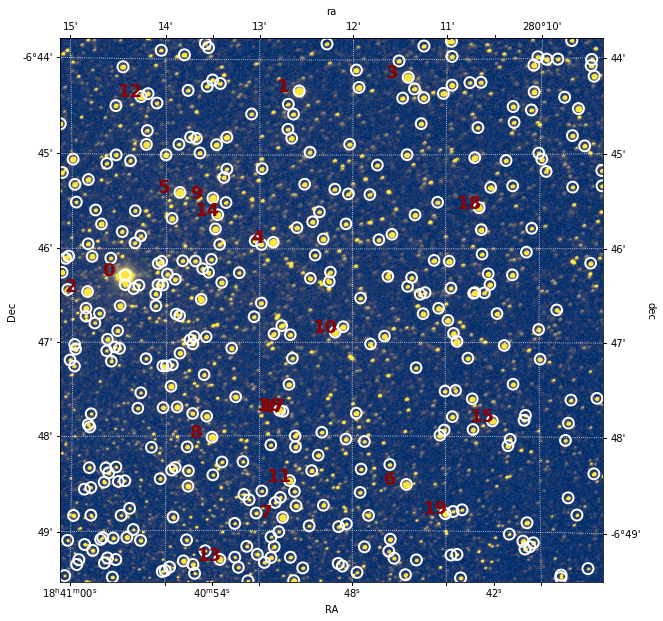

In [4]:
inst_mode = p['INSTMODE_PHOTOMETRY_KEYVALUE']

# get list of objects observed in photometric mode
objs = s4db.get_targets_observed(db, 
                                 inst_mode=inst_mode, 
                                 detector_mode=detector_modes[mode_key])

# select object's data 
if OBJECTID != "all" :
    objs = objs[objs['OBJECT'] == OBJECTID]

# loop over each object to run the reduction
for k in range(len(objs)) :
    obj = objs[k][0]
    
    # set suffix for output stack filename
    stack_suffix = "{}_s4c{}{}_{}".format(NIGHTDIR, 
                                          p['CHANNELS'][CHANNEL-1], 
                                          mode_key, 
                                          obj.replace(" ",""))
    
    # get list of science data matching object, detector mode, and inst. mode
    sci_list = s4db.get_file_list(db, 
                                  object_id=obj, 
                                  inst_mode=inst_mode, 
                                  obstype=p['OBJECT_OBSTYPE_KEYVALUE'], 
                                  detector_mode=detector_modes[mode_key])

    # run stack and reduce individual science images (produce *_proc.fits)
    p = s4pipelib.stack_and_reduce_sci_images(p,
                                              sci_list,
                                              p['reduce_directories'][CHANNEL-1],
                                              stack_suffix=stack_suffix,
                                              force=FORCE,
                                              match_frames=True,
                                              verbose=True,
                                              plot=True) 

## 2. Reduce scientific exposures in `POLARIMETRY HALF-WAVE` mode

12 Reference image: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002131_hd111.fits
OBJECT files: 16
Loading science frames to memory ... 


/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:


gain: 0.8 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 16 : 20230503_s4c4_002131_hd111.fits 
Calibrating science frame 2 of 16 : 20230503_s4c4_002122_hd111.fits 
Calibrating science frame 3 of 16 : 20230503_s4c4_002120_hd111.fits 
Calibrating science frame 4 of 16 : 20230503_s4c4_002121_hd111.fits 
Calibrating science frame 5 of 16 : 20230503_s4c4_002126_hd111.fits 
Calibrating science frame 6 of 16 : 20230503_s4c4_002132_hd111.fits 
Calibrating science frame 7 of 16 : 20230503_s4c4_002125_hd111.fits 
Calibrating science frame 8 of 16 : 20230503_s4c4_002128_hd111.fits 
Calibrating science frame 9 of 16 : 20230503_s4c4_002123_hd111.fits 
Calibrating science frame 10 of 16 : 20230503_s4c4_002119_hd111.fits 
Calibrating science frame 11 of 16 : 20230503_s4c4_002133_hd111.fits 
Calibrating science frame 12 of 16 : 20230503_s4c4_002124_hd111.fits 
Calibrating science frame 13 of 16 : 20230503_s4c4_002129_hd111.fits 
Calibrating science

2023-06-20 21:55:29,467 astropop - INFO - Registering image 1 from 16  [register]
2023-06-20 21:55:29,494 astropop - INFO - Images are equal, skipping registering.  [register]
2023-06-20 21:55:29,609 astropop - INFO - Registering image 2 from 16  [register]
2023-06-20 21:55:29,922 astropop - INFO - Filling registered image with cval=10.66  [register]
2023-06-20 21:55:29,923 astropop - INFO - Registering image with: translation=[0.21098383 0.54453411], rotation=-0.02°  [register]
2023-06-20 21:55:30,000 astropop - INFO - Registering image 3 from 16  [register]
2023-06-20 21:55:30,232 astropop - INFO - Filling registered image with cval=10.61  [register]
2023-06-20 21:55:30,232 astropop - INFO - Registering image with: translation=[0.16066746 0.1219382 ], rotation=-0.01°  [register]
2023-06-20 21:55:30,325 astropop - INFO - Registering image 4 from 16  [register]
2023-06-20 21:55:30,588 astropop - INFO - Filling registered image with cval=9.80  [register]
2023-06-20 21:55:30,589 astropop

Creating new catalog of detected sources:
Running loop 0 of 1 -> images in loop: 0 to 16 ... 


/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:


OBJECT files: 16
Creating output list of processed science frames ... 
1 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002119_hd111_proc.fits
2 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002120_hd111_proc.fits
3 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002121_hd111_proc.fits
4 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002122_hd111_proc.fits
5 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002123_hd111_proc.fits
6 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002124_hd111_proc.fits
7 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/2023050

2023-06-20 21:56:09,431 astropop - INFO - Computing shift of image 1 from 16  [register]


Calculating offsets ... 
Computing offsets with respect to the reference image: index=12 -> /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002131_hd111.fits


2023-06-20 21:56:09,663 astropop - INFO - Computing shift of image 2 from 16  [register]
2023-06-20 21:56:09,881 astropop - INFO - Computing shift of image 3 from 16  [register]
2023-06-20 21:56:10,091 astropop - INFO - Computing shift of image 4 from 16  [register]
2023-06-20 21:56:10,300 astropop - INFO - Computing shift of image 5 from 16  [register]
2023-06-20 21:56:10,527 astropop - INFO - Computing shift of image 6 from 16  [register]
2023-06-20 21:56:10,742 astropop - INFO - Computing shift of image 7 from 16  [register]
2023-06-20 21:56:10,956 astropop - INFO - Computing shift of image 8 from 16  [register]
2023-06-20 21:56:11,175 astropop - INFO - Computing shift of image 9 from 16  [register]
2023-06-20 21:56:11,382 astropop - INFO - Computing shift of image 10 from 16  [register]
2023-06-20 21:56:11,600 astropop - INFO - Computing shift of image 11 from 16  [register]
2023-06-20 21:56:11,821 astropop - INFO - Computing shift of image 12 from 16  [register]
2023-06-20 21:56:1

Running aperture photometry for catalogs with an offset by dx=0.13760758351281765 dy=0.5393140042585856
Saving frame 1 of 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002119_hd111.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002119_hd111_proc.fits
Running aperture photometry for catalogs with an offset by dx=0.1606674637058063 dy=0.12193820163497548
Saving frame 2 of 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002120_hd111.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002120_hd111_proc.fits
Running aperture photometry for catalogs with an offset by dx=-0.150696371596041 dy=-0.06695904055726487
Saving frame 3 of 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002121_hd111.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002121_hd111_proc.fits
Runnin

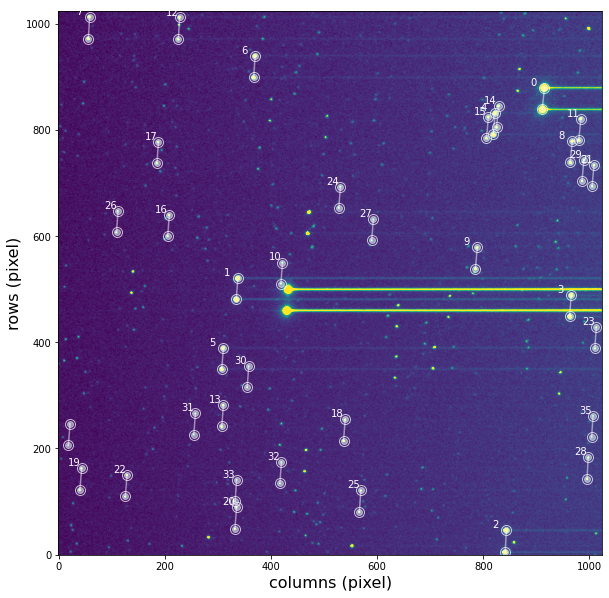

In [5]:
inst_mode = p['INSTMODE_POLARIMETRY_KEYVALUE']
polar_mode = p['POLARIMETRY_L2_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode,polar_mode)

# get list of objects observed in photometric mode
objs = s4db.get_targets_observed(db, 
                                 inst_mode=inst_mode, 
                                 polar_mode=polar_mode, 
                                 detector_mode=detector_modes[mode_key])
# select object's data    
if OBJECTID != "all" :
    objs = objs[objs['OBJECT'] == OBJECTID]

# loop over each object to run the reduction
for k in range(len(objs)) :
    obj = objs[k][0]
    
    # set suffix for output stack filename
    stack_suffix = "{}_s4c{}{}_{}{}".format(NIGHTDIR, 
                                            p['CHANNELS'][CHANNEL-1], 
                                            mode_key, 
                                            obj.replace(" ",""), 
                                            polsuffix)
    # get list of science data matching object, detector mode, inst. mode, and polar mode
    sci_list = s4db.get_file_list(db, 
                                  object_id=obj, 
                                  inst_mode=inst_mode, 
                                  polar_mode=polar_mode, 
                                  obstype=p['OBJECT_OBSTYPE_KEYVALUE'], 
                                  calwheel_mode=None, 
                                  detector_mode=detector_modes[mode_key])

    # run stack and reduce individual science images (produce *_proc.fits)
    p = s4pipelib.stack_and_reduce_sci_images(p,
                                              sci_list,
                                              p['reduce_directories'][CHANNEL-1],
                                              stack_suffix=stack_suffix,
                                              force=FORCE,
                                              match_frames=True,
                                              polarimetry=True,                                              
                                              verbose=True,
                                              plot=True) 

## 3. Reduce scientific exposures in `POLARIMETRY QUARTER-WAVE` mode

2 Reference image: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002137_hd1l4.fits
OBJECT files: 16
Loading science frames to memory ... 


/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:


gain: 0.8 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 16 : 20230503_s4c4_002137_hd1l4.fits 
Calibrating science frame 2 of 16 : 20230503_s4c4_002141_hd1l4.fits 
Calibrating science frame 3 of 16 : 20230503_s4c4_002138_hd1l4.fits 
Calibrating science frame 4 of 16 : 20230503_s4c4_002148_hd1l4.fits 
Calibrating science frame 5 of 16 : 20230503_s4c4_002147_hd1l4.fits 
Calibrating science frame 6 of 16 : 20230503_s4c4_002150_hd1l4.fits 
Calibrating science frame 7 of 16 : 20230503_s4c4_002135_hd1l4.fits 
Calibrating science frame 8 of 16 : 20230503_s4c4_002145_hd1l4.fits 
Calibrating science frame 9 of 16 : 20230503_s4c4_002140_hd1l4.fits 
Calibrating science frame 10 of 16 : 20230503_s4c4_002144_hd1l4.fits 
Calibrating science frame 11 of 16 : 20230503_s4c4_002142_hd1l4.fits 
Calibrating science frame 12 of 16 : 20230503_s4c4_002146_hd1l4.fits 
Calibrating science frame 13 of 16 : 20230503_s4c4_002139_hd1l4.fits 
Calibrating science

2023-06-20 21:58:18,699 astropop - INFO - Registering image 1 from 16  [register]
2023-06-20 21:58:18,720 astropop - INFO - Images are equal, skipping registering.  [register]


Registering science frames and stacking them ... 
0 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002137_hd1l4.fits
1 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002141_hd1l4.fits
2 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002138_hd1l4.fits
3 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002148_hd1l4.fits
4 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002147_hd1l4.fits
5 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002150_hd1l4.fits
6 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002135_hd1l4.fits
7 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002145_hd1l4.fits
8 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002140_hd1l4.fits
9 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002144_h

2023-06-20 21:58:18,793 astropop - INFO - Registering image 2 from 16  [register]
2023-06-20 21:58:19,037 astropop - INFO - Filling registered image with cval=10.45  [register]
2023-06-20 21:58:19,038 astropop - INFO - Registering image with: translation=[-0.99252016  0.50787676], rotation=-0.00°  [register]
2023-06-20 21:58:19,114 astropop - INFO - Registering image 3 from 16  [register]
2023-06-20 21:58:19,348 astropop - INFO - Filling registered image with cval=10.43  [register]
2023-06-20 21:58:19,348 astropop - INFO - Registering image with: translation=[-0.69659708  0.18053963], rotation=-0.01°  [register]
2023-06-20 21:58:19,423 astropop - INFO - Registering image 4 from 16  [register]
2023-06-20 21:58:19,655 astropop - INFO - Filling registered image with cval=10.38  [register]
2023-06-20 21:58:19,655 astropop - INFO - Registering image with: translation=[ 0.67448064 -0.36132319], rotation=0.01°  [register]
2023-06-20 21:58:19,728 astropop - INFO - Registering image 5 from 16  

Creating new catalog of detected sources:
Running loop 0 of 1 -> images in loop: 0 to 16 ... 


/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:


OBJECT files: 16
Creating output list of processed science frames ... 
1 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002135_hd1l4_proc.fits
2 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002136_hd1l4_proc.fits
3 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002137_hd1l4_proc.fits
4 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002138_hd1l4_proc.fits
5 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002139_hd1l4_proc.fits
6 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002140_hd1l4_proc.fits
7 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/2023050

2023-06-20 21:58:55,388 astropop - INFO - Computing shift of image 1 from 16  [register]


Calculating offsets ... 
Computing offsets with respect to the reference image: index=2 -> /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002137_hd1l4.fits


2023-06-20 21:58:55,618 astropop - INFO - Computing shift of image 2 from 16  [register]
2023-06-20 21:58:55,838 astropop - INFO - Computing shift of image 3 from 16  [register]
2023-06-20 21:58:55,839 astropop - INFO - Computing shift of image 4 from 16  [register]
2023-06-20 21:58:56,042 astropop - INFO - Computing shift of image 5 from 16  [register]
2023-06-20 21:58:56,242 astropop - INFO - Computing shift of image 6 from 16  [register]
2023-06-20 21:58:56,442 astropop - INFO - Computing shift of image 7 from 16  [register]
2023-06-20 21:58:56,662 astropop - INFO - Computing shift of image 8 from 16  [register]
2023-06-20 21:58:56,853 astropop - INFO - Computing shift of image 9 from 16  [register]
2023-06-20 21:58:57,071 astropop - INFO - Computing shift of image 10 from 16  [register]
2023-06-20 21:58:57,283 astropop - INFO - Computing shift of image 11 from 16  [register]
2023-06-20 21:58:57,480 astropop - INFO - Computing shift of image 12 from 16  [register]
2023-06-20 21:58:5

Running aperture photometry for catalogs with an offset by dx=0.6191343314940241 dy=0.4148444413658581
Saving frame 1 of 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002135_hd1l4.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002135_hd1l4_proc.fits
Running aperture photometry for catalogs with an offset by dx=0.3388154008606534 dy=0.7542803709068266
Saving frame 2 of 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002136_hd1l4.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002136_hd1l4_proc.fits
Running aperture photometry for catalogs with an offset by dx=0.0 dy=0.0
Saving frame 3 of 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_002137_hd1l4.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_002137_hd1l4_proc.fits
Running aperture photometry for catalogs

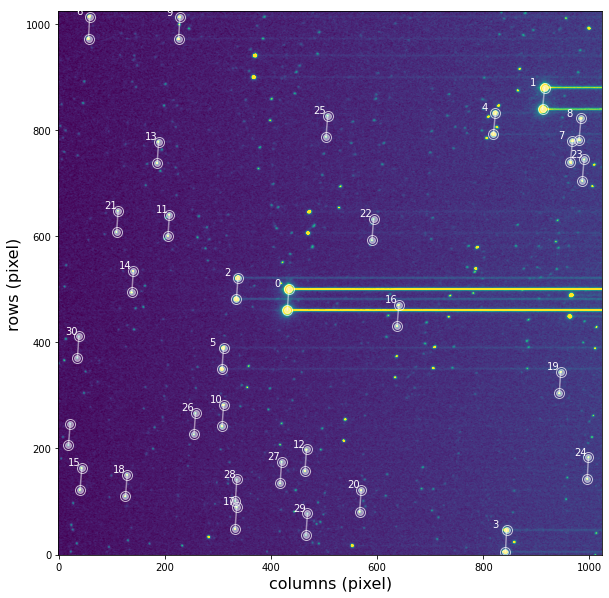

In [6]:
inst_mode = p['INSTMODE_POLARIMETRY_KEYVALUE']
polar_mode = p['POLARIMETRY_L4_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode,polar_mode)

# get list of objects observed in photometric mode
objs = s4db.get_targets_observed(db, 
                                 inst_mode=inst_mode, 
                                 polar_mode=polar_mode, 
                                 detector_mode=detector_modes[mode_key])
# select object's data    
if OBJECTID != "all" :
    objs = objs[objs['OBJECT'] == OBJECTID]

# loop over each object to run the reduction
for k in range(len(objs)) :
    obj = objs[k][0]
    
    # set suffix for output stack filename
    stack_suffix = "{}_s4c{}{}_{}{}".format(NIGHTDIR, 
                                            p['CHANNELS'][CHANNEL-1], 
                                            mode_key, 
                                            obj.replace(" ",""), 
                                            polsuffix)
    # get list of science data matching object, detector mode, inst. mode, and polar mode
    sci_list = s4db.get_file_list(db, 
                                  object_id=obj, 
                                  inst_mode=inst_mode, 
                                  polar_mode=polar_mode, 
                                  obstype=p['OBJECT_OBSTYPE_KEYVALUE'], 
                                  calwheel_mode=None, 
                                  detector_mode=detector_modes[mode_key])

    # run stack and reduce individual science images (produce *_proc.fits)
    p = s4pipelib.stack_and_reduce_sci_images(p,
                                              sci_list,
                                              p['reduce_directories'][CHANNEL-1],
                                              stack_suffix=stack_suffix,
                                              force=FORCE,
                                              match_frames=True,
                                              polarimetry=True,                                              
                                              verbose=True,
                                              plot=True) 